# Deep dive into a BSDF

## Overview

As you will soon discover, Mitsuba 2 can do much more than rendering. In this tutorial we will show how to instanciate a BSDF plugin using Python dictionaries and plot inspect its distribution function using `matplotlib` and `numpy`.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**

<ul>
  <li>Instanciate Mitsuba objects using Python dict and mitsuba.core.load_dict</li>
  <li>Perform vectorized computations using a JIT variant of Mitsuba</li>
  <li>Convert an drjit array into a numpy array</li>
</ul>
    
</div>


## Step 1 - setup

Of course, let's start with the usual Python imports! As emphasized in the previous tutorial, Mitsuba requires a specific variant to be set before performing any other imports or computations. For this tutorial, we are going to use one of the JIT vectorized variant of the system. This will allow us to write code as if it was operating on normal scalar values, and have it run on arbitrary-sized arrays of values on the CPU or GPU.

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

## Step 2 - Instanciate a BSDF

One easy way to instanciate Mitsuba objects (e.g. [Shape](../generated/plugins_shapes.html#sec-shapes), [BSDF](../generated/plugins_bsdfs.html#sec-bsdfs), ...) is using the [<code>mitsuba.load_dict</code>][1] function. This function takes as input a Python `dict` following a similar structure to the XML scene description and instantiates the corresponding plugin. In our scenario, we want to construct a [roughconductor BSDF](../generated/plugins_bsdfs.html#bsdf-roughconductor) with a high roughness value and a GGX microfacet distribution.

Refer to the [documentation](../src/python_interface/parsing_xml.html#creating-objects-using-python-dictionaries) for more information regarding the Python `dict` convention for [<code>mitsuba.load_dict</code>][1]



[1]: https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html?highlight=load_dict#mitsuba.core.load_dict

In [2]:
bsdf = mi.load_dict({
    'type': 'roughconductor',
    'alpha': 0.2,
    'distribution': 'ggx'
})

## Step 3 - Vectorized evaluation the BSDF

We will now evaluate this BSDF for a whole array of directions at once, leveraging the enabled vectorize backend.

In [3]:
def sph_to_dir(theta, phi):
    """Map spherical to Euclidean coordinates"""
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

# Create a (dummy) surface interaction to use for the evaluation
si = dr.zero(mi.SurfaceInteraction3f)

# Specify an incident direction with 45 degrees elevation
si.wi = sph_to_dir(dr.Pi * 45 / 180, 0.0)

# Create grid in spherical coordinates and map it onto the sphere
res = 300
theta_o, phi_o = dr.meshgrid(
    dr.linspace(mi.Float, 0,     dr.Pi,     res),
    dr.linspace(mi.Float, 0, 2 * dr.Pi, 2 * res)
)
wo = sph_to_dir(theta_o, phi_o)

# Evaluate the whole array (18000 directions) at once
values = bsdf.eval(mi.BSDFContext(), si, wo)

## Step 4 - Sampling the BSDF

In [4]:
def dir_to_sph(d):
    """Map  Euclidean to spherical coordinate"""
    theta = dr.abs(dr.atan(dr.sqrt(d.x ** 2 + d.y ** 2) / d.z))
    phi = dr.atan(d.y / d.x)
    return theta, phi

sampler = mi.load_dict({'type': 'independent'})
sampler.seed(0, 400)

bs, spec = bsdf.sample(mi.BSDFContext(), si, sampler.next_1d(), sampler.next_2d())

theta, phi = dir_to_sph(bs.wo)

## Step 4 - Plot the results

Dr.Jit arrays of any flavour can easily be converted to array type of other mainstream libraries, such as `numpy`, `PyTorch`, `JAX` and `TensorFlow`. For more detailed information on this, take a look at the extensive [drjit documentation](https://drjit.readthedocs.io/en/master/).
In our case we are going to convert our drjit array into a numpy array.

In [5]:
import numpy as np
values_np = np.array(values)

We can now use our favourite plotting library to visualize the BSDF distribution (here we use `matplotlib`).

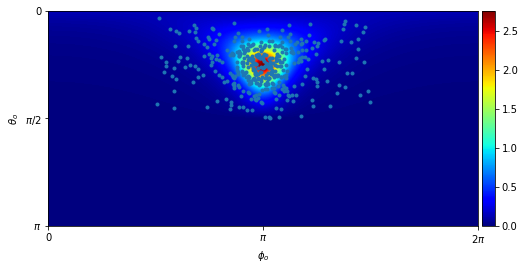

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Extract red channel of BRDF values and reshape into 2D grid
values_r = values_np[:, 0]
values_r = values_r.reshape(2 * res, res).T

# Plot values for spherical coordinates
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(values_r, extent=[0, 2 * np.pi, np.pi, 0], cmap='jet')
ax.plot(phi + dr.Pi, theta, '.')
ax.set_xlabel(r'$\phi_o$', size=10)
ax.set_xticks([0, dr.Pi, 2 * dr.Pi])
ax.set_xticklabels(['0', '$\\pi$', '$2\\pi$'])
ax.set_ylabel(r'$\theta_o$', size=10)
ax.set_yticks([0, dr.Pi / 2, dr.Pi])
ax.set_yticklabels(['0', '$\\pi/2$', '$\\pi$'])


cax = make_axes_locatable(ax).append_axes("right", size="3%", pad=0.05)
plt.colorbar(im, cax=cax);

<div class="admonition note alert alert-block alert-info">

📑 **See also**
    
<ul>
  <li><a href="url"><tt>mitsuba.load_dict</tt></a></li>
</ul>
    
</div>